## Prueba de modelos ##

### Version 4: Modelo con 2 DER, planificación anual, granularidad horaria ###

Si el modelo tiene que optimizar el balance por horas, tiene 8640 VD, pero sigue teniendo 2 VD binarias

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandapower as pp

In [44]:
import pyomo.environ as pe

In [53]:
import matplotlib.pyplot as plt

In [4]:
import ModelWriters as mw

In [21]:
import ModelWriters.Scenes as Scenes

In [30]:
import ModelWriters.Resources as Resources

In [394]:
net = pp.create_empty_network() 
b0 = pp.create_bus(net, vn_kv=13.2)

pp.create_ext_grid(net, bus=b0)

#ramal 1
b11 = pp.create_bus(net, vn_kv=13.2)
b12 = pp.create_bus(net, vn_kv=13.2)

pp.create_line(net, from_bus=b0, to_bus=b11, length_km=0.8, std_type="NAYY 4x50 SE")
pp.create_line(net, from_bus=b11, to_bus=b12, length_km=2.1, std_type="NAYY 4x50 SE")

pp.create_sgen(net, b11, p_mw=0.075, q_mvar=0.025, max_p_mw=0.15, max_q_mvar=0.15)
pp.create_load(net, bus=b12, p_mw=0.350)

#ramal 2
b21 = pp.create_bus(net, vn_kv=13.2)
pp.create_line(net, from_bus=b0, to_bus=b21, length_km=5.0, std_type="NAYY 4x50 SE")
pp.create_sgen(net, b21, p_mw=0.15, q_mvar=0.00, max_p_mw=0.40, max_q_mvar=0.10)
pp.create_storage(net, bus=b21, p_mw=0.25, q_mvar=0.1, max_e_mwh = 3.0)

#ramal 3
b31 = pp.create_bus(net, vn_kv=13.2)
b32 = pp.create_bus(net, vn_kv=13.2)
pp.create_line(net, from_bus=b0, to_bus=b31, length_km=0.5, std_type="NAYY 4x50 SE")
pp.create_line(net, from_bus=b31, to_bus=b32, length_km=1.5, std_type="NAYY 4x50 SE")
pp.create_sgen(net, b31, p_mw=0.08, q_mvar=0.00, max_p_mw=0.30, max_q_mvar=0.10)
pp.create_load(net, bus=b32, p_mw=0.85, q_mvar=0.33)


#ramal 4
b41 = pp.create_bus(net, vn_kv=13.2)
pp.create_line(net, from_bus=b0, to_bus=b41, length_km=0.5, std_type="NAYY 4x50 SE")
pp.create_load(net, bus=b41, p_mw=0.22, q_mvar=0.05)
#pp.create_storage(net, bus=b41, p_mw=0.5, q_mvar=0.1, max_e_mwh = 5.0)



2

In [393]:
net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,max_p_mw,max_q_mvar
0,None,1,0.075,0.025,NaN,1.0,True,wye,True,0.15,0.15
1,None,3,0.150,0.000,NaN,1.0,True,wye,True,0.40,0.10
2,None,4,0.080,0.000,NaN,1.0,True,wye,True,0.30,0.10


In [6]:
 pp.runpp(net)

In [7]:
print(net.res_bus.vm_pu)
print(net.res_line)

0    1.000000
1    0.998975
2    0.996269
3    1.000068
4    0.998349
5    0.993388
6    0.999583
Name: vm_pu, dtype: float64
   p_from_mw  q_from_mvar       p_to_mw     q_to_mvar     pl_mw   ql_mvar  \
0   0.351322    -0.033041 -3.509561e-01  2.390172e-02  0.000366 -0.009139   
1   0.350956    -0.023902 -3.500000e-01 -2.534783e-15  0.000956 -0.023902   
2   0.000015    -0.057478 -1.421276e-14 -1.768953e-15  0.000015 -0.057478   
3   0.856154     0.307957 -8.546254e-01 -3.134972e-01  0.001528 -0.005541   
4   0.854625     0.313497 -8.500000e-01 -3.300000e-01  0.004625 -0.016503   
5   0.220093     0.044267 -2.200000e-01 -5.000000e-02  0.000093 -0.005733   

   i_from_ka       i_to_ka      i_ka  vm_from_pu  va_from_degree  vm_to_pu  \
0   0.015434  1.540169e-02  0.015434    1.000000        0.000000  0.998975   
1   0.015402  1.536586e-02  0.015402    0.998975       -0.012487  0.996269   
2   0.002514  6.264008e-16  0.002514    1.000000        0.000000  1.000068   
3   0.039796  3.988161

In [8]:
print(net)

This pandapower network includes the following parameter tables:
   - bus (7 elements)
   - load (3 elements)
   - ext_grid (1 element)
   - line (6 elements)
 and the following results tables:
   - res_bus (7 elements)
   - res_line (6 elements)
   - res_ext_grid (1 element)
   - res_load (3 elements)


## Construcción de Escenarios

In [436]:
#s = Scenes.SceneBuilder(years = 4, subperiods = 1, days_in_subperiods = 1, dt=12, growth_rate = 0.025, discount_rate = 0.05)
#s = Scenes.SceneBuilder(years = 20, subperiods = 12, days_in_subperiods = 1, growth_rate = 0.025, discount_rate = 0.03)
s = Scenes.SceneBuilder(years = 20, subperiods = 12, days_in_subperiods = 1, growth_rate = 0.025, discount_rate = 0.03)
scenes = s.build_scenes()
scenes

,year,day,dd,hour,dt,growth,discount,solar_irradiance,wind_speed
0,0.0,0.0,30.416667,0.0,1.0,1.00000,1.000000,0.0,0.824324
1,0.0,0.0,30.416667,1.0,1.0,1.00000,1.000000,0.0,1.292458
2,0.0,0.0,30.416667,2.0,1.0,1.00000,1.000000,0.0,2.229691
3,0.0,0.0,30.416667,3.0,1.0,1.00000,1.000000,0.0,2.664774
4,0.0,0.0,30.416667,4.0,1.0,1.00000,1.000000,0.0,3.132269
...,...,...,...,...,...,...,...,...,...
5755,19.0,330.0,30.416667,19.0,1.0,1.59865,0.570286,0.0,8.168995
5756,19.0,330.0,30.416667,20.0,1.0,1.59865,0.570286,0.0,7.279864
5757,19.0,330.0,30.416667,21.0,1.0,1.59865,0.570286,0.0,7.101687
5758,19.0,330.0,30.416667,22.0,1.0,1.59865,0.570286,0.0,7.505210


## Model Construction

Construccion automatica del modelo
Es un modelo de dimensionamiento de 3 DERs (WT+PV)

In [437]:
model_writer = mw.SimpleModelWriter(net, scenes)

In [438]:
net.ext_grid['model'][0] = Resources.ExtGrid('SET', pr_mw = 5.0, peak_value=200, valley_value=120, rest_value=160)
#net.ext_grid['model'][0] = Resources.ExtGrid('SET', pr_mw = 5.0, peak_value=2000, valley_value=1500, rest_value=1000)

In [439]:
net.load['model'][0] = Resources.Load('Tornquinst', pr_mw = 0.35)
net.load['model'][1] = Resources.Load('Bell Ville', pr_mw = 0.85)
net.load['model'][2] = Resources.Load('City Bell', pr_mw = 0.22)

In [440]:
net.sgen['model'][0] = Resources.PVGenerator('PV1', ic_0_mu = 0.0, ic_1_mu = 1.02e6, oc_0_mu = 1.02, oc_1_mu = 0.0)
net.sgen['model'][1] = Resources.WTGeneratorDiscrete('WT1', unit_size_mw = 0.19, unit_cost_mu = 541e3, oc_0_mu = 0.00, oc_1_mu = 1.70)
net.sgen['model'][2] = Resources.PVGeneratorDiscrete('PV2', unit_size_mw = 0.05, unit_cost_mu = 51e3, oc_0_mu = 0.03, oc_1_mu = 0.0)

In [441]:
net.storage['model'][0] = Resources.Storage('ST1', ic_1_mu = 554e3, ic_1_mu_cap = 330e3, oc_1_mu = 2.28*4, eta_bb = 0.8, sigma = 2.1e-3)

## Resolution

In [442]:
model = model_writer.create_model()

In [443]:
#model.pprint()

In [444]:
#solver_manager = pe.SolverManagerFactory('neos')
#result_obj = solver_manager.solve(model.model, opt='cplex')

opt = pe.SolverFactory('cplex')
#opt = pe.SolverFactory('glpk')
result_obj= opt.solve(model, tee=True)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\jmsar\AppData\Local\Temp\tmp1ytp5for.cplex.log' open.
CPLEX> Problem 'C:\Users\jmsar\AppData\Local\Temp\tmpv6l6cd2x.pyomo.lp' read.
Read time = 0.11 sec. (5.00 ticks)
CPLEX> Problem name         : C:\Users\jmsar\AppData\Local\Temp\tmpv6l6cd2x.pyomo.lp
Objective sense      : Minimize
Variables            :   34572  [Nneg: 23046,  Box: 5760,  Free: 5760,
                                 Binary: 4,  General Integer: 2]
Objective nonzeros   :   17286
Linear constraints   :   51848  [Less: 40325,  Equal: 11523]
  Nonzeros           :  120932
  RHS nonzeros       :    5761

Variables       

In [445]:
model_writer.backconfigure_network()

In [446]:
model_writer.net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,max_p_mw,max_q_mvar,model
0,None,1,0.075,0.025,NaN,1.0,True,wye,True,2.029518,1.014759,Resource: PV1
1,None,3,0.150,0.000,NaN,1.0,True,wye,True,0.000000,0.000000,Resource: WT1
2,None,4,0.080,0.000,NaN,1.0,True,wye,True,1.950000,0.975000,Resource: PV2


In [447]:
net.sgen['model'][1].units.value

-0.0

In [448]:
model_writer.net.storage

,name,bus,p_mw,q_mvar,sn_mva,soc_percent,min_e_mwh,max_e_mwh,scaling,in_service,type,model
0,None,3,0.25,0.1,NaN,NaN,0.0,7.474662,1.0,True,None,Resource: ST1


In [449]:
Resultados = model_writer.get_scenes_results()

In [450]:
Resultados

,SET_p_mw,Tornquinst_p_mw,Bell Ville_p_mw,City Bell_p_mw,PV1_p_mw,WT1_p_mw,PV2_p_mw,ST1_p_mw,ST1_soc_mwh
0,0.307360,-0.082689,-0.171862,-0.052809,0.0,0.0,0.0,0.000000,0.000000
1,2.071969,-0.085531,-0.210548,-0.054848,0.0,0.0,0.0,-1.721043,1.376834
2,2.076887,-0.090090,-0.220990,-0.044764,0.0,0.0,0.0,-1.721043,2.750777
3,2.003196,-0.073152,-0.166209,-0.042792,0.0,0.0,0.0,-1.721043,4.121834
4,2.058280,-0.082384,-0.203492,-0.051362,0.0,0.0,0.0,-1.721043,5.490013
...,...,...,...,...,...,...,...,...,...
5755,0.856575,-0.580641,-1.547390,-0.449587,0.0,0.0,0.0,1.721043,3.104396
5756,1.058394,-0.625637,-1.685302,-0.468498,0.0,0.0,0.0,1.721043,1.721043
5757,1.773179,-0.633382,-1.619706,-0.474217,0.0,0.0,0.0,0.954127,0.954127
5758,0.184808,-0.210070,-0.374744,-0.128951,0.0,0.0,0.0,0.528957,0.528957


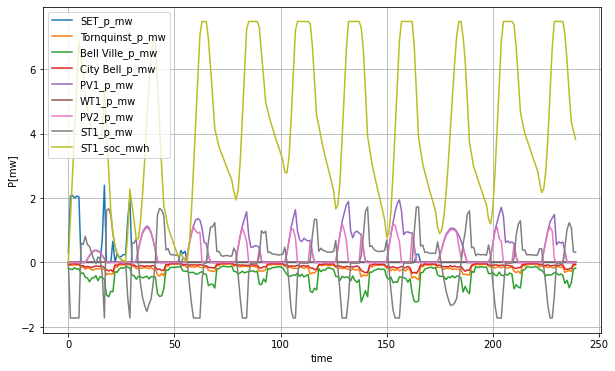

In [451]:
# Set the plot curve with markers and a title
fig, ax = plt.subplots(1, 1)

fig.set_size_inches(10,6)
#a=180*24
#b=360
#b=180*24+5*24
a=0
b=240
for col in Resultados:
    ax.plot(Resultados[col][a:b], label = col)

ax.set_xlabel('time')
ax.set_ylabel('P[mw]')

ax.legend()

ax.grid(True)


plt.show()